# Sesión 3. Deep Learning

Entrenamiento de red neuronal en navegador:

https://playground.tensorflow.org/

[Pytorch 2.0 speedup comparison](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html#demonstrating-speedups)

In [ ]:
!pip install --upgrade -q gspread

In [ ]:
import gspread
from google.colab import auth
auth.authenticate_user()
from google.auth import default

In [ ]:
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
url = #
worksheet = gc.open_by_url(url)
row = 4

In [ ]:
col = 3
value = 'X'
worksheet.get_worksheet(1).update_cell(row, col, value);

# CNN clásicas

In [ ]:
! pip install -q wandb torchmetrics torchsummary

In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision
import torchmetrics
import wandb
from torch import nn
from torchsummary import summary
from tqdm.auto import tqdm

## Operación de convolución

$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}.$$

In [ ]:
a = torch.arange(0, 9).reshape(3, 3)
a

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [ ]:
kernel = torch.arange(0, 4).reshape(2, 2)
kernel

tensor([[0, 1],
        [2, 3]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/correlation.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; height:1000vh; width:auto; max-height:0.6vh;"/>

In [ ]:
0*0 + 1*1 + 3*2 + 4*3

19

In [ ]:
F.conv2d(a.view(1, 1, a.shape[0], a.shape[1]), kernel.view(1, 1, kernel.shape[0], kernel.shape[1]))

tensor([[[[19, 25],
          [37, 43]]]])

In [ ]:
a.reshape((1, 1, 3, 3)).shape

torch.Size([1, 1, 3, 3])

## Detección de bordes

Verticales

In [ ]:
x = torch.ones((6, 8))
x[:, 2:6] = 0
x

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
kernel_v = torch.tensor([[1.0, -1.0]])
kernel_v

tensor([[ 1., -1.]])

In [ ]:
F.conv2d(x.view(1, 1, x.shape[0], x.shape[1]), kernel_v.view(1, 1, kernel_v.shape[0], kernel_v.shape[1]))

tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]])

Horizontales

In [ ]:
kernel_h = torch.tensor([[1.0],  [-1.0]])
kernel_h

tensor([[ 1.],
        [-1.]])

In [ ]:
x_transp = x.T
F.conv2d(x_transp.view(1, 1, x_transp.shape[0], x_transp.shape[1]), kernel_h.view(1, 1, kernel_h.shape[0], kernel_h.shape[1]))

tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 1.,  1.,  1.,  1.,  1.,  1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [-1., -1., -1., -1., -1., -1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.]]]])

Diagonales

In [ ]:
x_ident = torch.eye(6)
x_ident

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])

In [ ]:
kernel_d = torch.Tensor([[0, 1], [-1, 0]])
kernel_d

tensor([[ 0.,  1.],
        [-1.,  0.]])

In [ ]:
F.conv2d(x_ident.view(1, 1, x_ident.shape[0], x_ident.shape[1]), kernel_d.view(1, 1, kernel_d.shape[0], kernel_d.shape[1]))

tensor([[[[ 0., -1.,  0.,  0.,  0.],
          [ 1.,  0., -1.,  0.,  0.],
          [ 0.,  1.,  0., -1.,  0.],
          [ 0.,  0.,  1.,  0., -1.],
          [ 0.,  0.,  0.,  1.,  0.]]]])

In [ ]:
batch_size = 256

transf = torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])

emnist_train = torchvision.datasets.EMNIST(
    root="data", split='balanced', train=True, transform=transf, download=True)
emnist_test = torchvision.datasets.EMNIST(
    root="data", split='balanced', train=False, transform=transf, download=True)

train_dataloader = torch.utils.data.DataLoader(emnist_train, batch_size,
                                               shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(emnist_test, batch_size,
                                               shuffle=False, num_workers=1)

labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [ ]:
x_train, y_train = next(iter(train_dataloader))

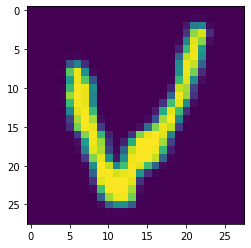

In [ ]:
plt.imshow(x_train[2, 0])

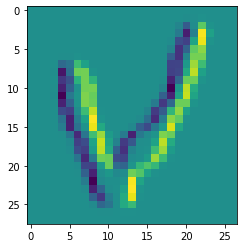

In [ ]:
img = F.conv2d(x_train[2, 0].view(1, 1, x_train[2, 0].shape[0], x_train[2, 0].shape[1]),
               kernel_v.view(1, 1, kernel_v.shape[0], kernel_v.shape[1]))
plt.imshow(img[0, 0])

Trabajo individual: probar con diferentes valores del kernel
Trabajo individual: probar detectar la punta superior de las letras

## Entrenamiento del kernel

In [ ]:
def train(model, dataloader, optimizer, loss_fn, device):
    train_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        train_loss += loss.sum()
        optimizer.step()
    
    return train_loss

In [ ]:
def test(model, dataloader, metrics_fn, loss_fn, device):
    with torch.no_grad():
        metrics_fn.reset()
        test_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            test_loss += loss.sum()
            metrics = metrics_fn(y_pred, y)
        metrics = metrics_fn.compute()
    
    return test_loss, metrics

In [ ]:
class ConvModel(nn.Module):
    '''
    Modelo Capas Convolucionales
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 64, 5)
        self.conv3 = nn.Conv2d(64, 8, 5)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(8*16*16, 47)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = self.linear(x)

        return x

In [ ]:
batch_size = 64

transf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

emnist_train = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transf, download=True)
emnist_test = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transf, download=True)

train_dataloader = torch.utils.data.DataLoader(emnist_train, batch_size,
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(emnist_test, batch_size,
                                               shuffle=False)

labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
          'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = ConvModel().to(device)

lr = 1e-2

# Función de pérdida
loss_fn = nn.CrossEntropyLoss()
# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Métrica de evaluación
metrics_fn = torchmetrics.Accuracy().to(device)
# Número de epochs
n_epochs = 5

config = {
  "learning_rate":lr,
  "epochs": n_epochs,
  "batch_size": batch_size,
  'optimizer': optimizer.__class__.__name__
}
wandb.init(project="Sesión 2", name='Redes convolucionales', config=config);


best_accuracy = 0
for epoch in range(n_epochs):
    _ = train(model, train_dataloader, optimizer, loss_fn, device)
    train_loss, train_metrics = test(model, train_dataloader, metrics_fn, loss_fn, device)
    wandb.log({"Train loss": train_loss/len(train_dataloader)}, step=epoch)
    wandb.log({"Train accuracy": train_metrics}, step=epoch)

    print('Epoch {}, Precisión (train): {:.4f}, Loss (train): {:.4f}'.format(epoch,
                                                        train_metrics,
                                                        train_loss/len(train_dataloader)))
        
    test_loss, test_metrics = test(model, test_dataloader, metrics_fn, loss_fn, device)
    wandb.log({"Test loss": test_loss/len(test_dataloader)}, step=epoch)
    wandb.log({"Test accuracy": test_metrics}, step=epoch)

    print('Epoch {}, Precisión (test): {:.4f}, Loss (test): {:.4f}'.format(epoch,
                                                        test_metrics,
                                                        test_loss/len(test_dataloader)))
    
    if test_metrics < best_accuracy:
        best_accuracy = test_metrics

    print(' ')

wandb.finish()

Epoch 0, Precisión (train): 0.8420, Loss (train): 0.4445
Epoch 0, Precisión (test): 0.8295, Loss (test): 0.4780
 
Epoch 1, Precisión (train): 0.8487, Loss (train): 0.4158
Epoch 1, Precisión (test): 0.8359, Loss (test): 0.4581
 
Epoch 2, Precisión (train): 0.8508, Loss (train): 0.4187
Epoch 2, Precisión (test): 0.8390, Loss (test): 0.4602
 
Epoch 3, Precisión (train): 0.8554, Loss (train): 0.3927
Epoch 3, Precisión (test): 0.8398, Loss (test): 0.4412
 
Epoch 4, Precisión (train): 0.8589, Loss (train): 0.3914
Epoch 4, Precisión (test): 0.8452, Loss (test): 0.4425
 


Test accuracy,▁▄▅▆█
Test loss,█▄▅▁▁
Train accuracy,▁▄▅▇█
Train loss,█▄▅▁▁
Test accuracy,0.8452
Test loss,0.44254
Train accuracy,0.8589
Train loss,0.39143


In [ ]:
col = 5
value = best_accuracy
worksheet.get_worksheet(1).update_cell(row, col, float(value));

## Optimización del entrenamiento

- GPU
- num_workers
- batch_size

In [ ]:
batch_size = 256

transf = torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])

emnist_train = torchvision.datasets.EMNIST(
    root="data", split='balanced', train=True, transform=transf, download=True)
emnist_test = torchvision.datasets.EMNIST(
    root="data", split='balanced', train=False, transform=transf, download=True)

train_dataloader = torch.utils.data.DataLoader(emnist_train, batch_size,
                                               shuffle=True, num_workers=1,
                                               pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(emnist_test, batch_size,
                                              shuffle=False, num_workers=1,
                                              pin_memory=True)

labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

### CPU

In [ ]:
%%timeit -n 1 -r 1
# batch_size = 16, num_workers = 1
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    l = loss(y_pred, y)
    l.backward()
    optimizer.step()

1 loop, best of 1: 3min 21s per loop


In [ ]:
%%timeit -n 1 -r 1
# batch_size = 256, num_workers = 1
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    l = loss(y_pred, y)
    l.backward()
    optimizer.step()

1 loop, best of 1: 3min 18s per loop


Paralelización num_workers tortilla de patatas

### GPU

In [ ]:
%%timeit -n 1 -r 1
# batch_size = 16, num_workers = 1
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    l = loss(y_pred, y)
    l.backward()
    optimizer.step()

1 loop, best of 1: 41.7 s per loop


In [ ]:
%%timeit -n 1 -r 1
# batch_size = 256, num_workers = 1
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    l = loss(y_pred, y)
    l.backward()
    optimizer.step()

1 loop, best of 1: 17.3 s per loop


### Número de parámetros

In [ ]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 64, 5)
        self.conv3 = nn.Conv2d(64, 8, 5)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(8*16*16, 47)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = self.linear(x)

        return x

In [ ]:
model = ConvModel()

In [ ]:
summary(model.to(torch.device('cuda')), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
            Conv2d-2           [-1, 64, 20, 20]          25,664
            Conv2d-3            [-1, 8, 16, 16]          12,808
           Flatten-4                 [-1, 2048]               0
            Linear-5                   [-1, 47]          96,303
Total params: 135,191
Trainable params: 135,191
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.52
Estimated Total Size (MB): 0.82
----------------------------------------------------------------


In [ ]:
w1 = 1*16*5*5 + 16
w1

416

In [ ]:
w2 = 16*64*5*5 + 64
w2

25664

In [ ]:
w3 = 64*8*5*5 + 8
w3

12808

In [ ]:
w4 = 8*16*16*47 + 47
w4

96303

In [ ]:
w1 + w2 + w3 + w4

135191

Normalmente, al procesar las imágenes, se busca reducir gradualmente la resolución espacial de las representaciones ocultas, agregando la información de forma que, cuanto más subimos en la red, mayor es el campo receptivo (en la entrada) al que es sensible cada neurona.

- Feature map
- Receptive field

In [ ]:
class ConvModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 9)
        self.conv2 = nn.Conv2d(16, 64, 9)
        self.conv3 = nn.Conv2d(64, 8, 9)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(8*4*4, 47)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = self.linear(x)

        return x

In [ ]:
model2 = ConvModel2()

In [ ]:
summary(model2.to(torch.device('cuda')), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 20, 20]           1,312
            Conv2d-2           [-1, 64, 12, 12]          83,008
            Conv2d-3              [-1, 8, 4, 4]          41,480
           Flatten-4                  [-1, 128]               0
            Linear-5                   [-1, 47]           6,063
Total params: 131,863
Trainable params: 131,863
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.50
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


## Padding

In [ ]:
a = torch.arange(0, 9).reshape(3, 3)
a

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [ ]:
# Left, right, up, down
a_pad = F.pad(a, (1, 1, 1, 1))
a_pad

tensor([[0, 0, 0, 0, 0],
        [0, 0, 1, 2, 0],
        [0, 3, 4, 5, 0],
        [0, 6, 7, 8, 0],
        [0, 0, 0, 0, 0]])

In [ ]:
kernel = torch.arange(0, 4).reshape(2, 2)
kernel

tensor([[0, 1],
        [2, 3]])

In [ ]:
F.conv2d(a_pad.view(1, 1, a_pad.shape[0], a_pad.shape[1]), kernel.view(1, 1, kernel.shape[0], kernel.shape[1]))

tensor([[[[ 0,  3,  8,  4],
          [ 9, 19, 25, 10],
          [21, 37, 43, 16],
          [ 6,  7,  8,  0]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-pad.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; height:1000vh; width:auto; max-height:0.6vh;"/>

In [ ]:
F.conv2d(a.view(1, 1, a.shape[0], a.shape[1]), kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),
         padding=(1, 1))

tensor([[[[ 0,  3,  8,  4],
          [ 9, 19, 25, 10],
          [21, 37, 43, 16],
          [ 6,  7,  8,  0]]]])

In [ ]:
F.conv2d(a.view(1, 1, a.shape[0], a.shape[1]), kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),
         padding='same')

tensor([[[[19, 25, 10],
          [37, 43, 16],
          [ 7,  8,  0]]]])

## Stride

In [ ]:
F.conv2d(a_pad.view(1, 1, a_pad.shape[0], a_pad.shape[1]), kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),
         stride=(3, 2))

tensor([[[[0, 8],
          [6, 8]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-stride.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; height:1000vh; width:auto; max-height:0.6vh;"/>

In [ ]:
class ConvModelStride(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2)
        self.conv2 = nn.Conv2d(16, 64, 5, stride=2)
        self.conv3 = nn.Conv2d(64, 8, 3)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(8*2*2, 47)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = self.linear(x)

        return x

In [ ]:
model_stride = ConvModelStride()

In [ ]:
summary(model_stride.to(torch.device('cuda')), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             416
            Conv2d-2             [-1, 64, 4, 4]          25,664
            Conv2d-3              [-1, 8, 2, 2]           4,616
           Flatten-4                   [-1, 32]               0
            Linear-5                   [-1, 47]           1,551
Total params: 32,247
Trainable params: 32,247
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.12
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


## Pooling

In [ ]:
a = torch.arange(0, 9, dtype=torch.float32).reshape(3, 3)
a

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [ ]:
F.max_pool2d(a.unsqueeze(0), (2, 2), stride=1)

tensor([[[4., 5.],
         [7., 8.]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/pooling.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; height:1000vh; width:auto; max-height:0.6vh;"/>

## Múltiples canales de entrada y salida

In [ ]:
a = torch.stack([torch.arange(0, 9).reshape(3, 3), torch.arange(1, 10).reshape(3, 3)])
a

tensor([[[0, 1, 2],
         [3, 4, 5],
         [6, 7, 8]],

        [[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [ ]:
kernel = torch.stack([torch.arange(0, 4).reshape(2, 2), torch.arange(1, 5).reshape(2, 2)])
kernel

tensor([[[0, 1],
         [2, 3]],

        [[1, 2],
         [3, 4]]])

In [ ]:
F.conv2d(a.unsqueeze(0), kernel.unsqueeze(0))

tensor([[[[ 56,  72],
          [104, 120]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-multi-in.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; height:1000vh; width:auto; max-height:0.7vh;"/>

## Convolución 1x1

In [ ]:
a = torch.arange(0, 3*3*3).reshape(3, 3, 3)
a

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23],
         [24, 25, 26]]])

In [ ]:
kernel = torch.arange(0, 6).reshape(2, 3, 1, 1)
kernel

tensor([[[[0]],

         [[1]],

         [[2]]],


        [[[3]],

         [[4]],

         [[5]]]])

In [ ]:
F.conv2d(a.unsqueeze(0), kernel)

tensor([[[[ 45,  48,  51],
          [ 54,  57,  60],
          [ 63,  66,  69]],

         [[126, 138, 150],
          [162, 174, 186],
          [198, 210, 222]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-1x1.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; height:1000vh; width:auto; max-height:0.7vh;"/>

## CNN completa

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1)
        self.conv2 = nn.Conv2d(16, 256, 3, stride=1)
        self.conv3 = nn.Conv2d(256, 16, 3, stride=2)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(784, 47)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=(3, 3), stride=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=(3, 3), stride=1))
        x = F.relu(F.max_pool2d(self.conv3(x), kernel_size=(3, 3), stride=1))
        x = self.flat(x)
        x = self.linear(x)

        return x

In [ ]:
summary(CNN(), (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
            Conv2d-2          [-1, 256, 22, 22]          37,120
            Conv2d-3             [-1, 16, 9, 9]          36,880
           Flatten-4                  [-1, 784]               0
            Linear-5                   [-1, 47]          36,895
Total params: 111,055
Trainable params: 111,055
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.04
Params size (MB): 0.42
Estimated Total Size (MB): 1.47
----------------------------------------------------------------


In [ ]:
batch_size = 64

transf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

emnist_train = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transf, download=True)
emnist_test = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transf, download=True)

train_dataloader = torch.utils.data.DataLoader(emnist_train, batch_size,
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(emnist_test, batch_size,
                                               shuffle=False)

labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
          'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = ConvModel().to(device)

lr = 1e-3

# Función de pérdida
loss_fn = nn.CrossEntropyLoss()
# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Métrica de evaluación
metrics_fn = torchmetrics.Accuracy().to(device)
# Número de epochs
n_epochs = 5

config = {
  "learning_rate":lr,
  "epochs": n_epochs,
  "batch_size": batch_size,
  'optimizer': optimizer.__class__.__name__
}
wandb.init(project="Sesión 2", name='CNN completa', config=config);


best_accuracy = 0
for epoch in range(n_epochs):
    _ = train(model, train_dataloader, optimizer, loss_fn, device)
    train_loss, train_metrics = test(model, train_dataloader, metrics_fn, loss_fn, device)
    wandb.log({"Train loss": train_loss/len(train_dataloader)}, step=epoch)
    wandb.log({"Train accuracy": train_metrics}, step=epoch)

    print('Epoch {}, Precisión (train): {:.4f}, Loss (train): {:.4f}'.format(epoch,
                                                        train_metrics,
                                                        train_loss/len(train_dataloader)))
        
    test_loss, test_metrics = test(model, test_dataloader, metrics_fn, loss_fn, device)
    wandb.log({"Test loss": test_loss/len(test_dataloader)}, step=epoch)
    wandb.log({"Test accuracy": test_metrics}, step=epoch)

    print('Epoch {}, Precisión (test): {:.4f}, Loss (test): {:.4f}'.format(epoch,
                                                        test_metrics,
                                                        test_loss/len(test_dataloader)))
    
    if test_metrics < best_accuracy:
        best_accuracy = test_metrics

    print(' ')

wandb.finish()

# Mejora del rendimiento

## LR scheduler

[LR scheduler Pytorch](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR()
scheduler = torch.optim.lr_scheduler.ExponentialLR()

## Optimizadores 

[Optimizadores Pytorch](https://pytorch.org/docs/stable/optim.html#algorithms)


Choi, D., Shallue, C. J., Nado, Z., Lee, J., Maddison, C. J., & Dahl, G. E. (2019). **On empirical comparisons of optimizers for deep learning.**  arXiv preprint arXiv:1910.05446. [Paper](https://arxiv.org/pdf/1910.05446.pdf)

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/optimizers.png"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; height:1000vh; width:auto; max-height:0.9vh;"/>

## Aumentación de datos

In [ ]:
# Diferentes transforms en train y test
torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(18),
    torchvision.transforms.RandomHorizontalFlip(0.25),
    torchvision.transforms.RandomVerticalFlip(0.25),
    torchvision.transforms.RandomAffine(15),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    torchvision.transforms.ToTensor()
])

Compose(
    RandomResizedCrop(size=(18, 18), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.25)
    RandomVerticalFlip(p=0.25)
    RandomAffine(degrees=[-15.0, 15.0])
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ToTensor()
)

# LeNet

Comentar Premio Príncipe de Asturias

LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324. [Paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=726791&casa_token=kyltN8hTCx0AAAAA:uFdBXu6A_S6S4cpFwgx2_d3tAosoljC-2VWHpvIB8nCIlUbHAaxNO_3iZkeNgEUDVbvmlGJeVQ&tag=1)

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/lenet-vert.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; height:1000vh; width:auto; max-height:0.8vh;"/>

- Entrada (28 x 28)
- 6 filtros convolucionales, kernel 5 x 5, padding=2
 - Función de activación sigmoide
 - Average pooling 2 x 2, stride=2
- 16 filtros convolucionales, kernel 5 x 5
 - Función de activación sigmoide
 - Average pooling 2 x 2, stride=2
- Lineal 120 neuronas
  - Función de activación sigmoide
- Lineal 84 neuronas
  - Función de activación sigmoide
- Lineal num_clases neuronas

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 47)
)

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 47]           3,995
Total params: 64,851
Trainable params: 64,851
Non-trainable params: 0
---------------------------------

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

lr = 1e-3
gamma = 0.8
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
metrics_fn = torchmetrics.Accuracy().to(device)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [ ]:
n_epochs = 10

for epoch in range(n_epochs):
    train(model, train_dataloader, optimizer, loss_fn, device)

    loss, metrics = test(model, train_dataloader, metrics_fn, loss_fn, device)
    print('Epoch {}, Precisión (train): {:.3f}, Loss (train): {:.4f}'.format(epoch, metrics, loss.mean()))
        
    loss, metrics = test(model, test_dataloader, metrics_fn, loss_fn, device)
    print('Epoch {}, Precisión (test): {:.3f}, Loss (test): {:.4f}\n'.format(epoch, metrics, loss.mean()))

    scheduler.step()

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM" -O 'data/celeba/img_align_celeba.zip' && rm -rf /tmp/cookies.txt

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


# CNN modernas

Hablar de Imagenet - Transfer Learning

## AlexNet

Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. Advances in neural information processing systems, 25.

[Paper](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/alexnet.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; height:1000vh; width:auto; max-height:1.2vh;"/>

In [ ]:
batch_size = 64
transf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224))
])

gtsrb_train = torchvision.datasets.GTSRB(
    root="data", split='train', transform=transf, download=True)
gtsrb_test = torchvision.datasets.GTSRB(
    root="data", split='test', transform=transf, download=True)

train_dataloader = torch.utils.data.DataLoader(gtsrb_train, batch_size,
                                               shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(gtsrb_test, batch_size,
                                               shuffle=False, num_workers=1)

In [ ]:
model = torchvision.models.AlexNet(num_classes=43).to(device)

In [ ]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
model = nn.Sequential(
    # Aquí, utilizamos una ventana más grande de 11 x 11 para capturar 
    # los objetos. Al mismo tiempo, utilizamos un stride de 4 para reducir
    # en gran medida la altura y la anchura de la salida. Aquí, el número 
    # de canales de salida es mucho mayor que en LeNet
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    # Hacemos la ventana de convolución más pequeña, con un padding de 2
    # para que sea consistente el alto y ancho de la entrada y la salida,
    #  y aumentar el número de canales de salida
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    # Usamos tres capas convolucionales sucesivas y una ventana de convolución
    # más pequeña. Excepto en la última capa convolucional, el número de canales
    # de salida se incrementa. Las capas de pooling no se utilizan para reducir
    # el alto y ancho de la entrada después de las dos primeras capas convolucionales
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),

    # El número de salidas de la capa lineal es órdenes de magnitud más grande 
    # que en LeNet. Se emplea el dropout para reducir el overfitting
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),

    # Capa de salida, el número de canales de salida debe ser el número de
    # clases del dataset
    nn.Linear(4096, 43))

In [ ]:
x, y = next(iter(train_dataloader))

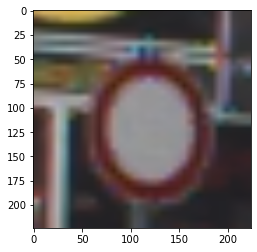

In [ ]:
plt.imshow(x[0].permute(1, 2, 0))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

lr = 1e-3
gamma = 0.8
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
metrics_fn = torchmetrics.Accuracy().to(device)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [ ]:
n_epochs = 10

for epoch in range(n_epochs):
    train(model, train_dataloader, optimizer, loss_fn, device)

    loss, metrics = test(model, train_dataloader, metrics_fn, loss_fn, device)
    print('Epoch {}, Precisión (train): {:.3f}, Loss (train): {:.4f}'.format(epoch, metrics, loss.mean()))
        
    loss, metrics = test(model, test_dataloader, metrics_fn, loss_fn, device)
    print('Epoch {}, Precisión (test): {:.3f}, Loss (test): {:.4f}\n'.format(epoch, metrics, loss.mean()))

    scheduler.step()

Epoch 0, Precisión (train): 0.601, Loss (train): 1.4727
Epoch 0, Precisión (test): 0.520, Loss (test): 2.5482

Epoch 1, Precisión (train): 0.905, Loss (train): 0.0602
Epoch 1, Precisión (test): 0.803, Loss (test): 1.4694

Epoch 2, Precisión (train): 0.941, Loss (train): 0.0915
Epoch 2, Precisión (test): 0.833, Loss (test): 1.4653

Epoch 3, Precisión (train): 0.975, Loss (train): 0.0041
Epoch 3, Precisión (test): 0.864, Loss (test): 1.8084

Epoch 4, Precisión (train): 0.984, Loss (train): 0.0291
Epoch 4, Precisión (test): 0.879, Loss (test): 1.4687

Epoch 5, Precisión (train): 0.989, Loss (train): 0.1985
Epoch 5, Precisión (test): 0.876, Loss (test): 1.4062

Epoch 6, Precisión (train): 0.995, Loss (train): 0.0004
Epoch 6, Precisión (test): 0.897, Loss (test): 1.1950

Epoch 7, Precisión (train): 0.993, Loss (train): 0.0001
Epoch 7, Precisión (test): 0.893, Loss (test): 1.7245

Epoch 8, Precisión (train): 0.995, Loss (train): 0.0114
Epoch 8, Precisión (test): 0.892, Loss (test): 2.0889

E

## VGG (transfer learning)

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/vgg.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; height:1000vh; width:auto; max-height:1.2vh;"/>

In [ ]:
model = torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ansu/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Eliminar última capa y añadir capa propia con 43 clases

## ResNet

In [ ]:
model = torchvision.models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/ansu/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## EfficientNet (B0 - B7)

In [ ]:
model = torchvision.models.efficientnet_b7(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /home/ansu/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

In [ ]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              SiLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]             576
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              SiLU-6         [-1, 64, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]           1,040
              SiLU-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 64, 1, 1]           1,088
          Sigmoid-11             [-1, 64, 1, 1]               0
SqueezeExcitation-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 32, 112, 112]           2,048
      BatchNorm2d-14         [-1, 32, 1